In [1]:
%load_ext autoreload
import race
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
import optuna
import importlib
import CurvyRaceEnv
importlib.reload(CurvyRaceEnv)
%matplotlib inline
%reload_ext autoreload

pygame 2.5.2 (SDL 2.28.3, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Users\schmidtfa\MasterStudium\PythonEnvironment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from stable_baselines3.common.env_checker import check_env
#import CurvyRaceEnv
test = CurvyRaceEnv.CurvyRaceEnv()
check_env(test)

c:\Users\schmidtfa\MasterStudium\PythonEnvironment\Lib\site-packages\stable_baselines3\common\env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(
c:\Users\schmidtfa\MasterStudium\PythonEnvironment\Lib\site-packages\stable_baselines3\common\env_checker.py:452: UserWarning: Your action space has dtype float64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


In [3]:
from gymnasium.envs.registration import register

register(
     id="CurvyRaceEnv-v0",
     entry_point="CurvyRaceEnv:CurvyRaceEnv",
     max_episode_steps=100,
)

In [4]:
from typing import Any
from typing import Dict

import gymnasium
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import StopTrainingOnNoModelImprovement
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback

import torch
import torch.nn as nn
import time
N_TRIALS = 10000
N_STARTUP_TRIALS = 5
N_EVALUATIONS = 2
N_TIMESTEPS = 20000
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_EPISODES = 3

ENV_ID = "CurvyRaceEnv-v0"

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": ENV_ID,
}

In [5]:
def evaluate_model(model, env, num_episodes=100):  
    
    total_reward = 0.0
    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done,info, _ = env.step(action)
            total_reward += reward
    mean_reward = total_reward / num_episodes
    return mean_reward

In [6]:
from stable_baselines3 import A2C, PPO, TD3, DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

def objective(trial: optuna.Trial) -> float:   
    hyperparams = {
        "neg_reward_small": trial.suggest_int("neg_reward_small", -10, -1),
        "neg_reward_big": trial.suggest_int("neg_reward_big", -50, -10),
        "pos_reward_factor": trial.suggest_int("pos_reward_factor", 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'buffer_size': trial.suggest_int('buffer_size', 1000, 100000),
        'gamma': trial.suggest_float('gamma', 0.9, 0.999),
        'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True)   
    }
    # Define the environment
    env = gymnasium.make('CurvyRaceEnv-v0', pos_reward_factor=hyperparams["pos_reward_factor"],neg_reward_small=hyperparams["neg_reward_small"],neg_reward_big=hyperparams["neg_reward_big"])  
    


    
    
    

    # Create and train the DDPG model
    model = DDPG('MlpPolicy', env, learning_rate=hyperparams['learning_rate'], buffer_size=hyperparams['buffer_size'],
                 gamma=hyperparams['gamma'], tau=hyperparams['tau'],
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))
    
    # Train the model
    model.learn(total_timesteps=10000)  # Adjust the total_timesteps as needed

    # Evaluate the model
    mean_reward = evaluate_model(model, env)

    return mean_reward

In [7]:
#study = optuna.create_study(study_name="DDPG", storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
#study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

In [8]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import DDPG, TD3, SAC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


env = gymnasium.make("CurvyRaceEnv-v0")
env = Monitor(env, "logs/ddpg")
#model_ddpg = DDPG("MlpPolicy", env,action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)),  learning_rate=0.004859847958257243,tau=0.06431401009446525,  gamma = 0.9703705891833702, buffer_size=82149)
#model_ddpg.learn(total_timesteps=10000)
#model_ddpg.save("models/model_ddpg")
#_, _ = env.reset()
#del model_ddpg

#env = Monitor(env, "logs/td3")
#model_td3 = TD3("MlpPolicy", env,  learning_rate=2e-3,policy_kwargs=dict(net_arch=[400,300]), learning_starts=5000,gradient_steps=-1, gamma = 0.9, buffer_size=200000)
#model_td3.learn(total_timesteps=25000)
#model_td3.save("models/model_td3")
#_, _ = env.reset()
#del model_td3

env = Monitor(env, "logs/sac")
model_sac = SAC("MlpPolicy", env,  learning_rate=0.004859847958257243,tau=0.06431401009446525,  gamma = 0.9703705891833702, buffer_size=82149)
model_sac.learn(total_timesteps=50000)
model_sac.save("models/model_sac")
_, _ = env.reset()
del model_sac

c:\Users\schmidtfa\MasterStudium\PythonEnvironment\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


In [16]:
env.close()

In [22]:
def run_env(env, model):
    obs, info = env.reset()
    done = False
    reward_list = []
    observation_list = []
    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, info, _ = env.step(action)
        print(obs)
        observation_list.append(obs)
        reward_list.append(rewards)
        env.render()    
    return reward_list

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_rewards(rewards):
    """
    Plots the cumulative rewards per episode.
    """
    # Calculate the cumulative sum of the list elements
    cumulative_rewards = {key: np.cumsum(value) for key, value in rewards.items()}

    # Plot the cumulative rewards
    for key, value in cumulative_rewards.items():
        plt.plot(value, label=key)

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()


In [25]:
import pandas as pd
def load_log(path):
    data =  pd.read_csv(path, index_col=None).index.tolist()[1:]    
    return [float(x) for x in data]

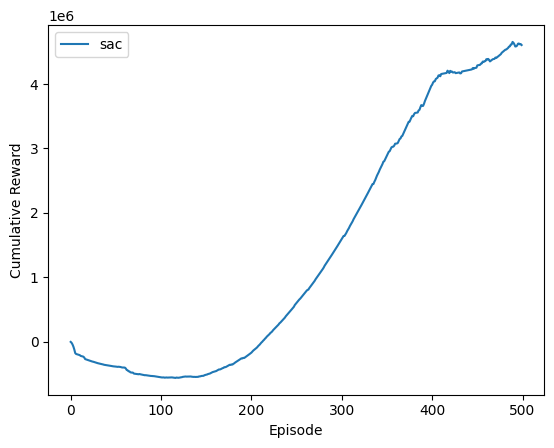

In [26]:
from stable_baselines3 import DDPG,SAC, TD3
#ddpg = DDPG.load("models/model_ddpg.zip")
sac = SAC.load("models/model_sac.zip")
#td3 = TD3.load("models/model_td3.zip")

test = gymnasium.make("CurvyRaceEnv-v0")

rewards = {}
#rewards["DDPG"] = load_log("logs/ddpg.monitor.csv")
rewards["sac"] = load_log("logs/sac.monitor.csv")
#rewards["td3"] = load_log("logs/td3.monitor.csv")



plot_cumulative_rewards(rewards)

c:\Users\schmidtfa\MasterStudium\PythonEnvironment\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


[ 0.03046018 -0.07749132  0.24852176  2.9121425   1.        ]


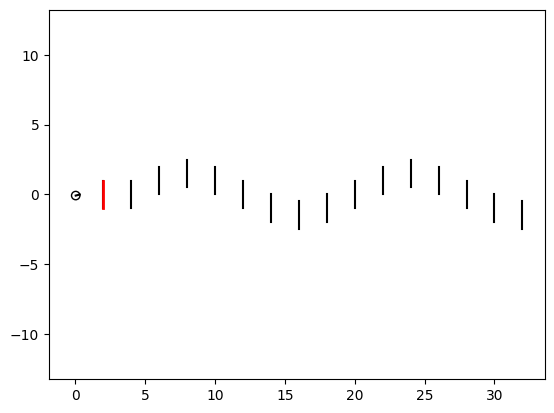

[ 0.03046018 -0.07749132  0.6457962   2.9121425   2.        ]


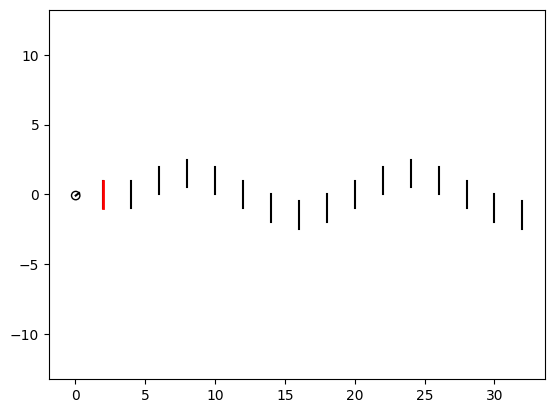

[ 0.03046018 -0.07749132  1.0323758   2.9121425   3.        ]


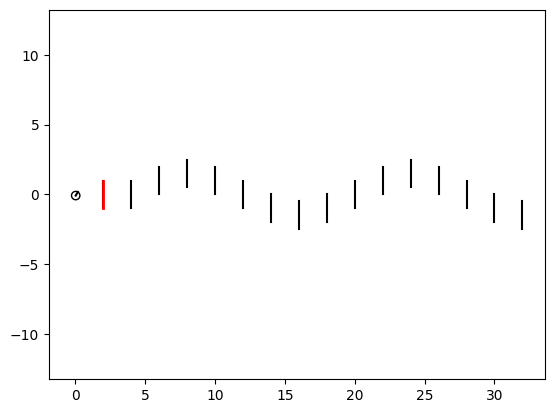

[ 0.03046018 -0.07749132  1.4034344   2.9121425   4.        ]


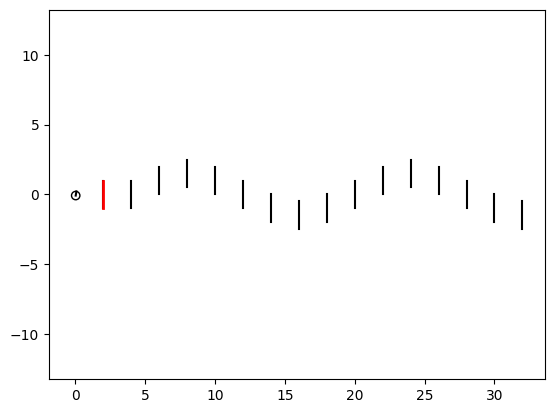

[ 0.03046018 -0.07749132  1.190079    2.9121425   5.        ]


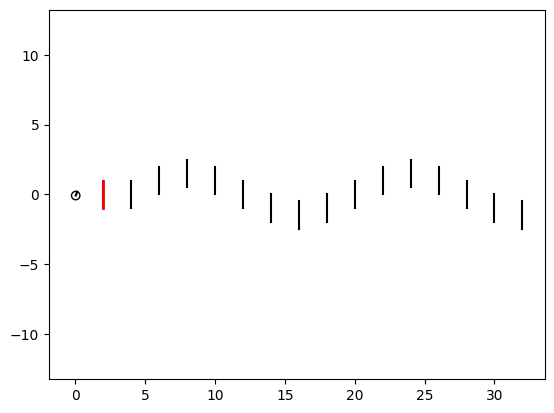

[ 0.03046018 -0.07749132  0.852807    2.9121425   6.        ]


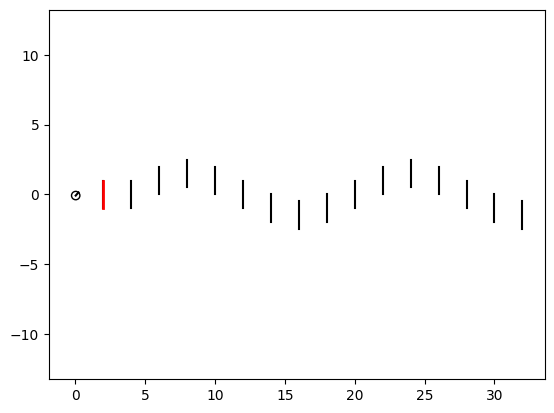

[ 0.06821646 -0.03426803  0.47230655  2.8747816   7.        ]


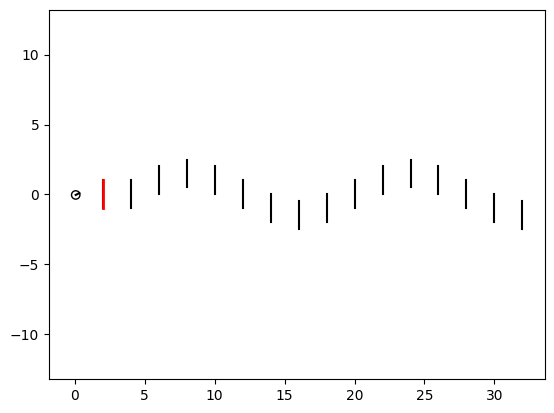

[ 0.06821646 -0.03426803  0.09365436  2.8747816   8.        ]


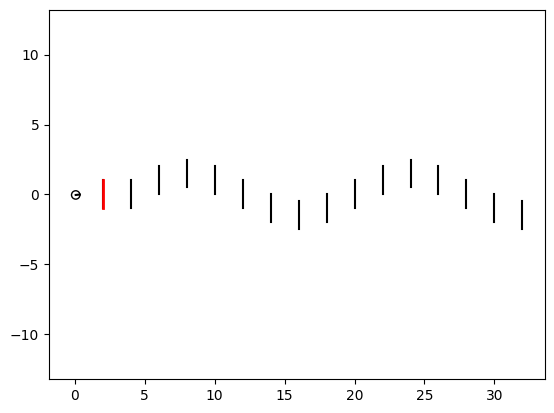

[ 0.06821646 -0.03426803 -0.041448    2.8747816   9.        ]


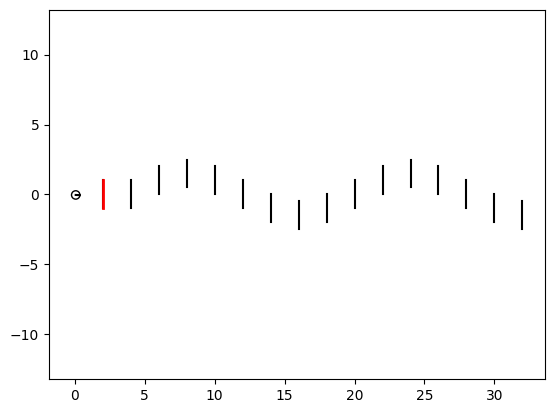

[ 0.20532651 -0.03995422  0.29030296  2.7797024  10.        ]


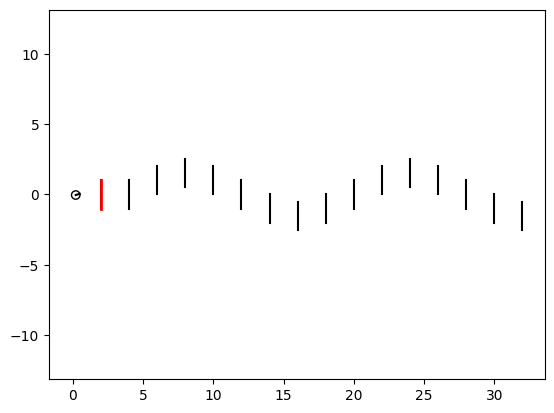

[ 0.43506363  0.02867808  0.32107168  2.6096942  11.        ]


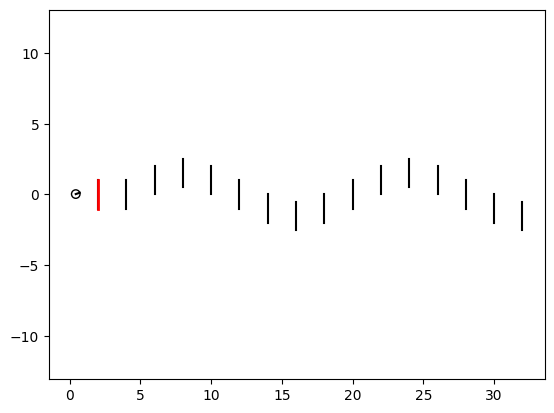

[ 1.1555663   0.2683023   0.02140071  2.1600976  12.        ]


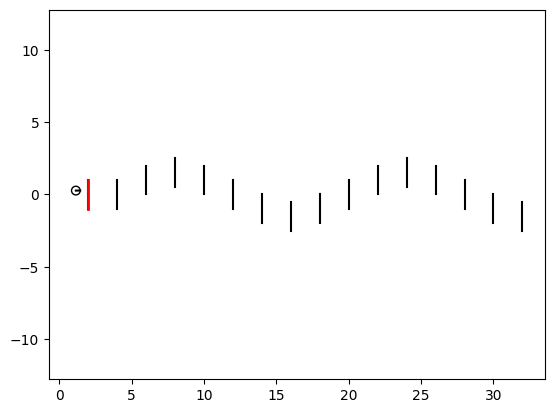

[ 1.8813113   0.28383613 -0.07263947  1.9274251  13.        ]


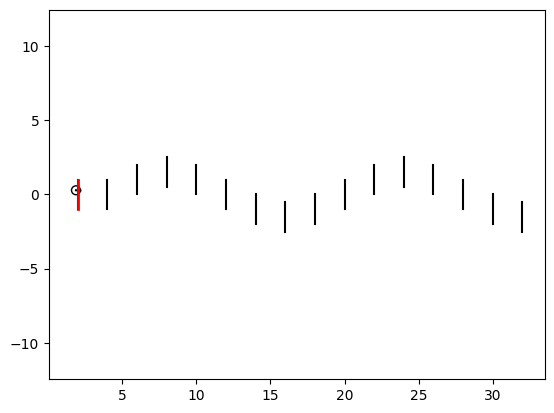

[ 2.0113072   0.27437666 -0.15379786  2.6947799   0.        ]


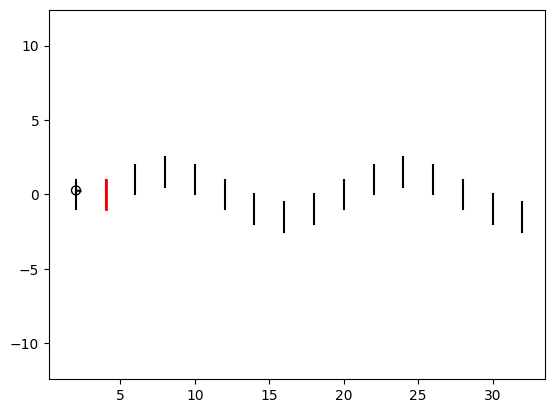

[2.7862682  0.1542406  0.24046803 2.2626257  1.        ]


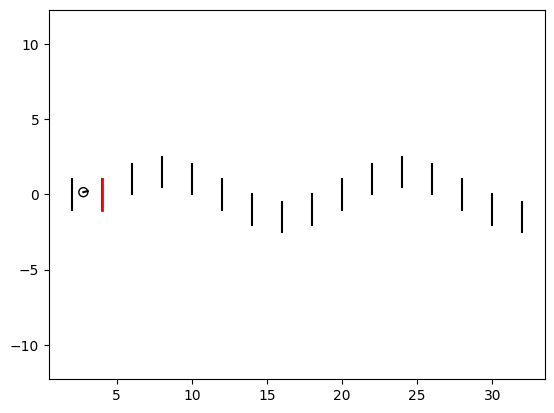

[3.5583527  0.34356564 0.508931   1.8586193  2.        ]


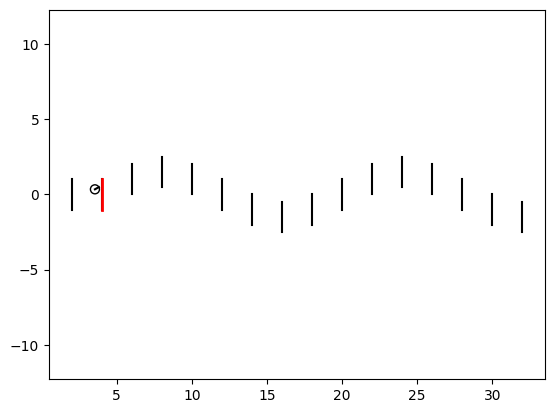

[4.2551847  0.7323672  0.11520705 2.7226744  0.        ]


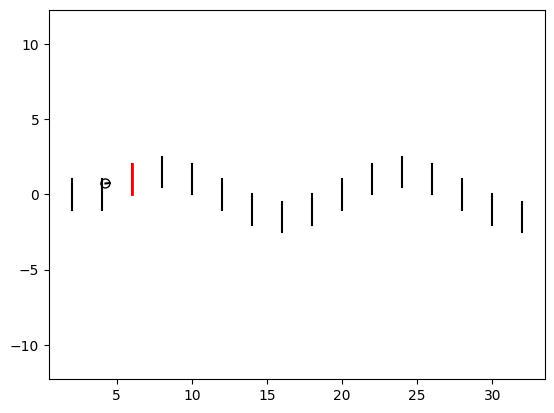

[5.0253873  0.8214947  0.22409567 2.2168474  1.        ]


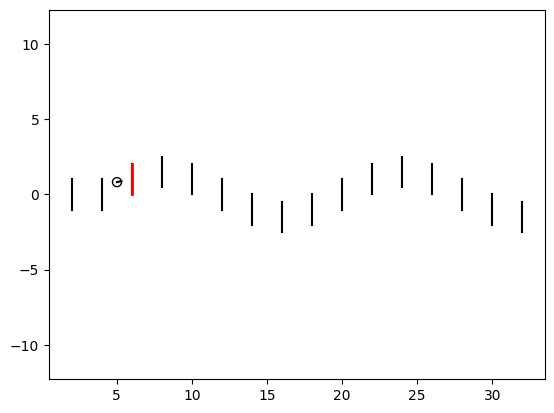

[5.8014383  0.99837524 0.19071715 1.8135061  2.        ]


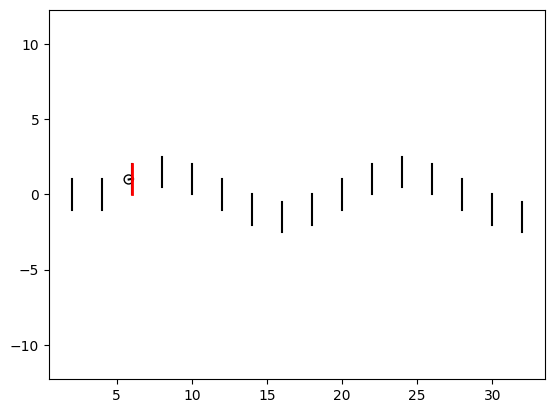

[6.5784435  1.1483867  0.22949068 2.5271902  0.        ]


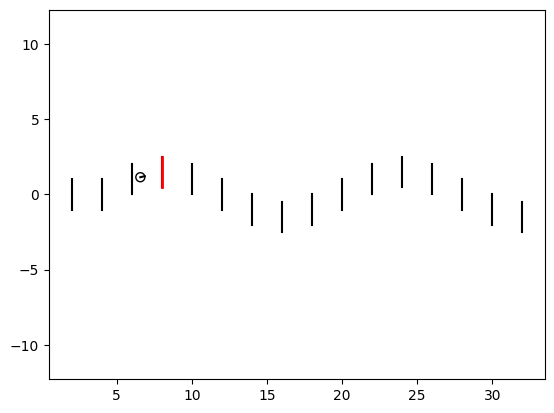

[7.333569  1.3247886 0.5004879 2.0297644 1.       ]


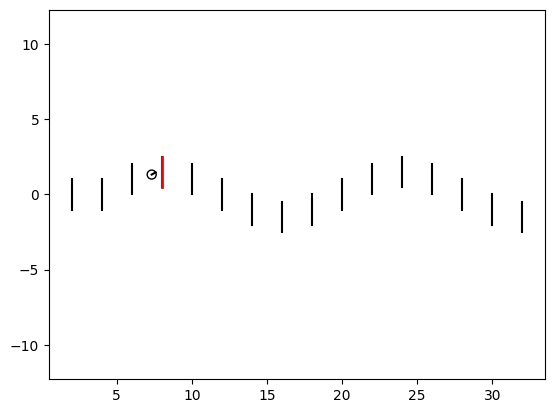

[8.005834   1.6924745  0.79250735 2.3450046  0.        ]


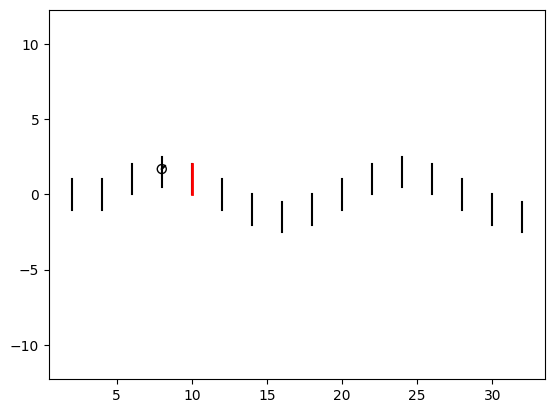

[8.207987  1.8975227 1.0099256 2.140187  1.       ]


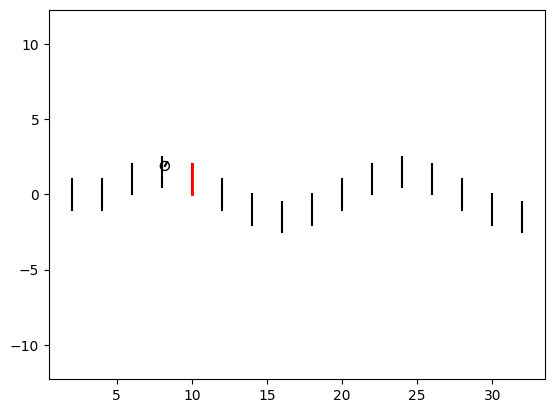

[8.214355  1.9076605 0.9918076 2.1324728 2.       ]


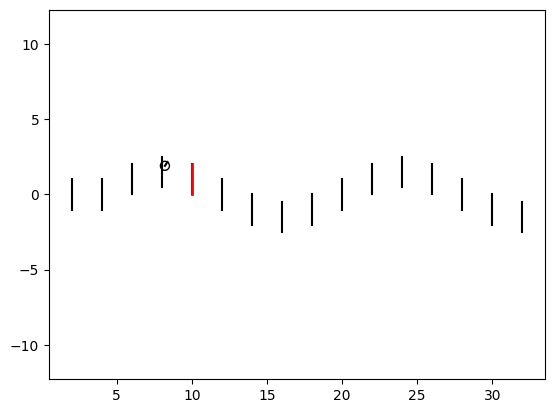

[8.588174  2.4794908 0.9886215 1.7560459 3.       ]


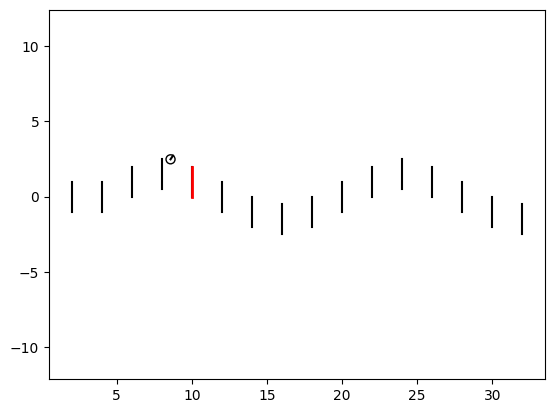

[8.588174  2.4794908 0.9131021 1.7560459 4.       ]


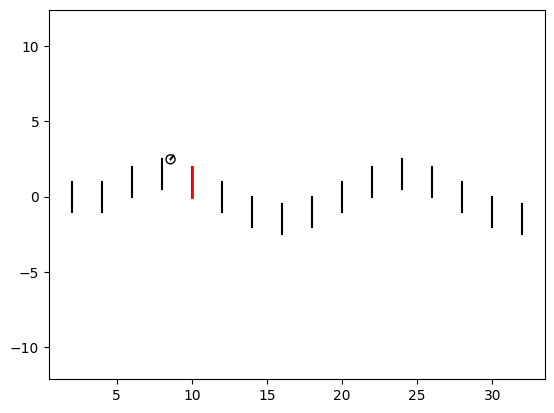

[8.862381  2.8344896 1.2947376 1.6042864 5.       ]


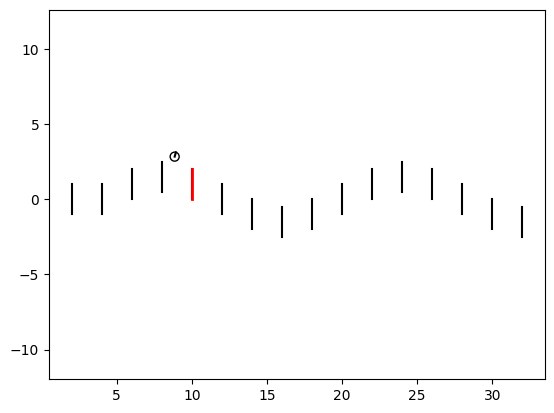

[8.862381  2.8344896 1.643486  1.6042864 6.       ]


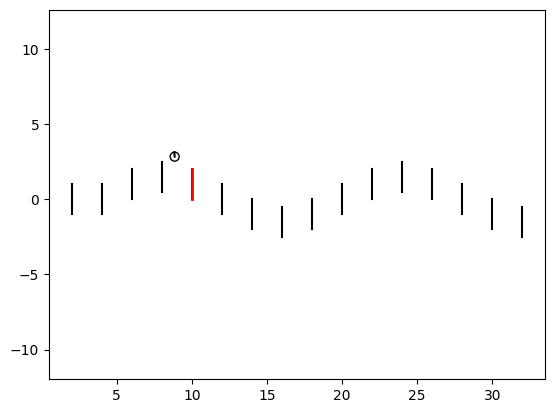

[8.862381  2.8344896 1.9755987 1.6042864 7.       ]


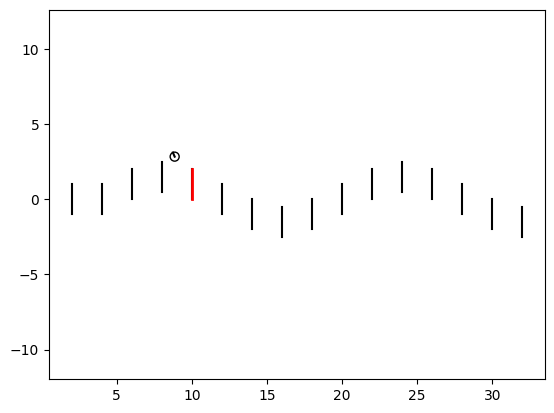

[8.862381  2.8344896 2.2143862 1.6042864 8.       ]


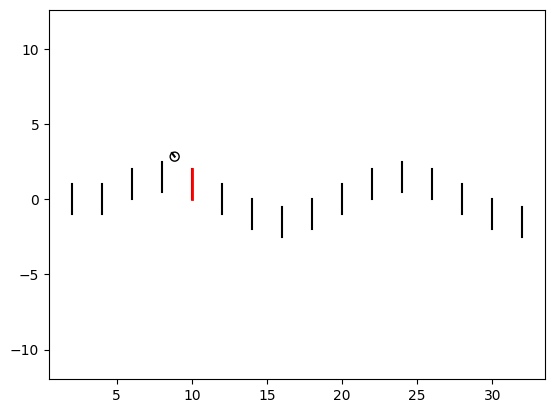

[8.862381  2.8344896 2.5068967 1.6042864 9.       ]


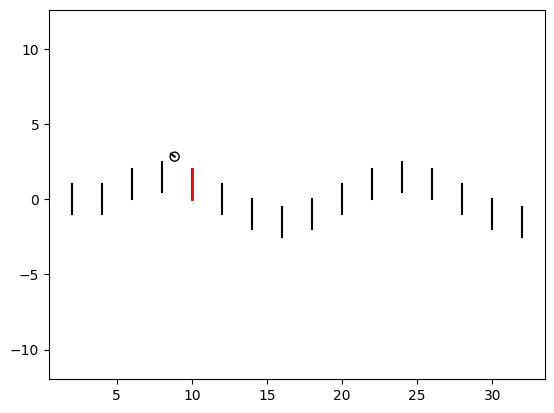

[ 8.862381   2.8344896  2.715444   1.6042864 10.       ]


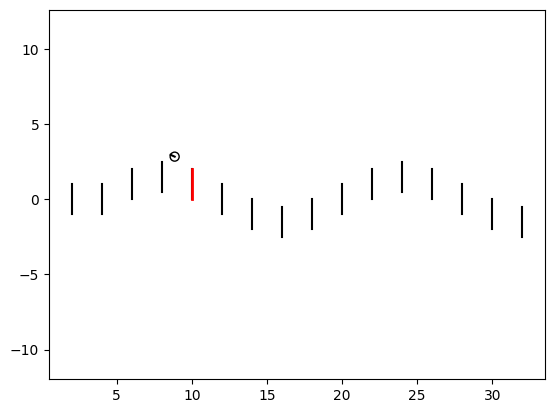

[ 8.862381   2.8344896  2.6967604  1.6042864 11.       ]


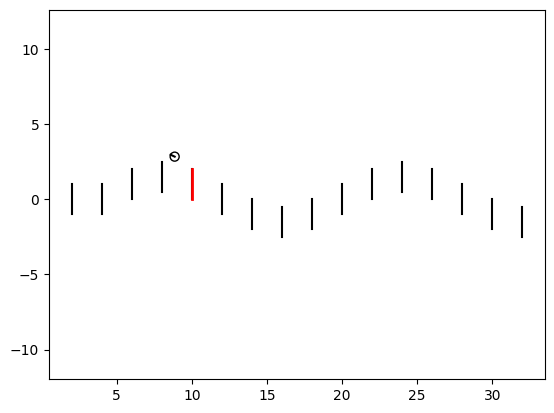

[ 8.735403   2.8950198  3.0315998  1.6194212 12.       ]


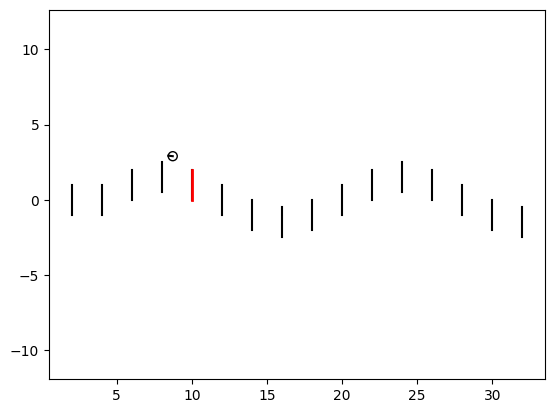

[ 8.735403   2.8950198  3.2405717  1.6194212 13.       ]


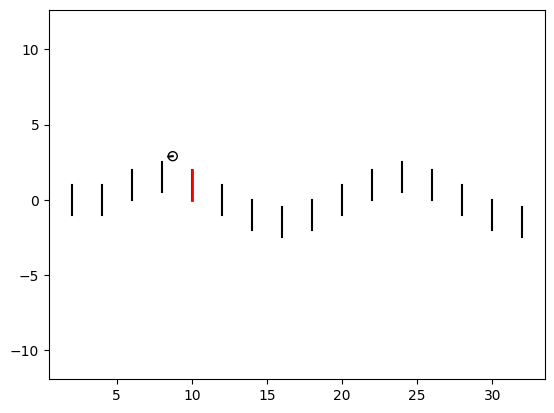

[ 8.549805   2.876589   3.3774197  1.6676418 14.       ]


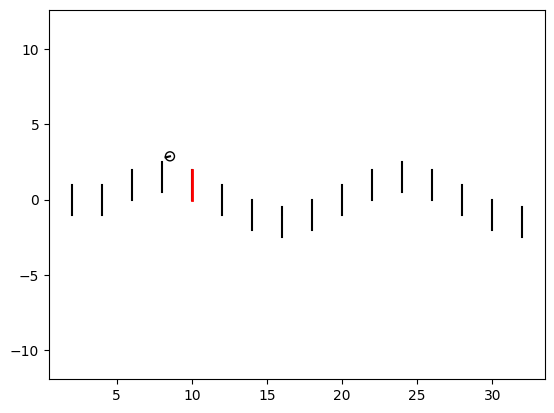

[ 8.549805   2.876589   3.296252   1.6676418 15.       ]


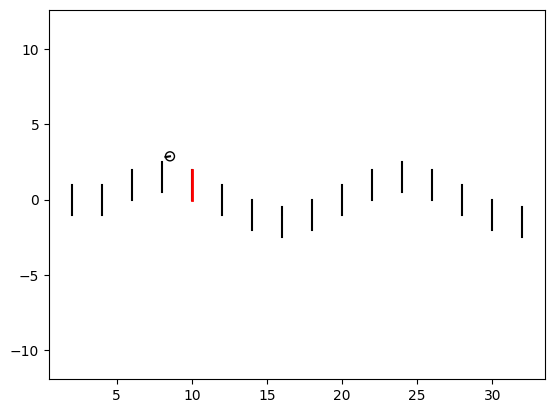

[ 8.549805   2.876589   3.0780418  1.6676418 16.       ]


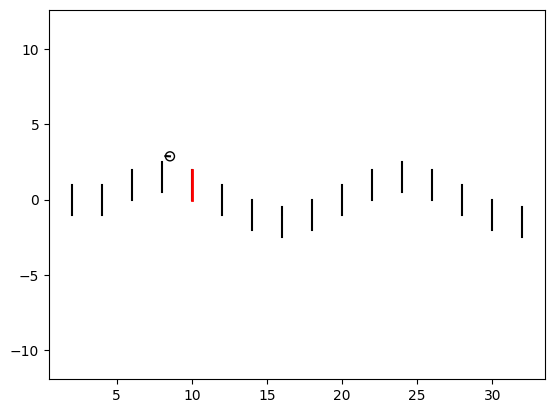

[ 8.549805   2.876589   2.7303371  1.6676418 17.       ]


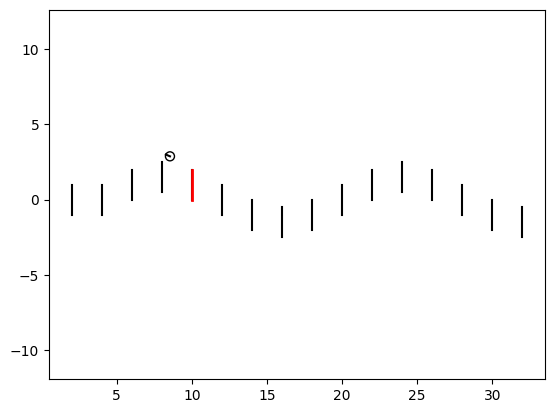

[ 8.549805   2.876589   2.7990725  1.6676418 18.       ]


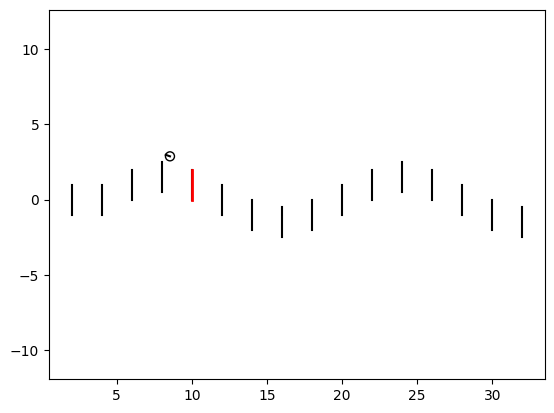

[ 8.549805   2.876589   2.456413   1.6676418 19.       ]


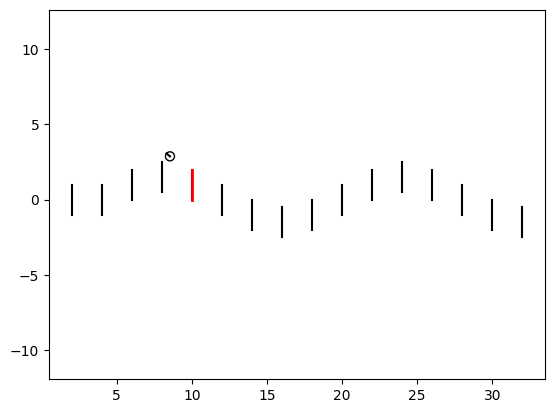

[ 8.549805   2.876589   2.093524   1.6676418 20.       ]


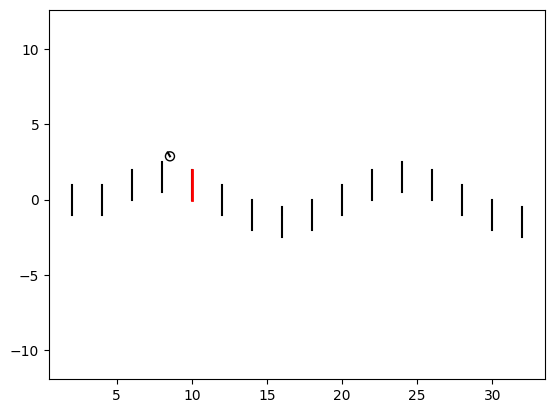

[ 8.549805   2.876589   2.0030782  1.6676418 21.       ]


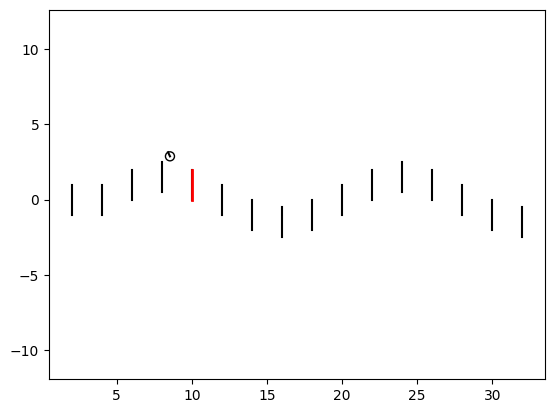

[ 8.549805   2.876589   1.6649697  1.6676418 22.       ]


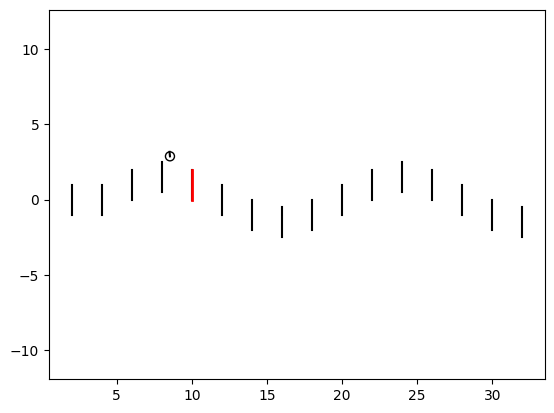

[ 8.549805   2.876589   1.2936116  1.6676418 23.       ]


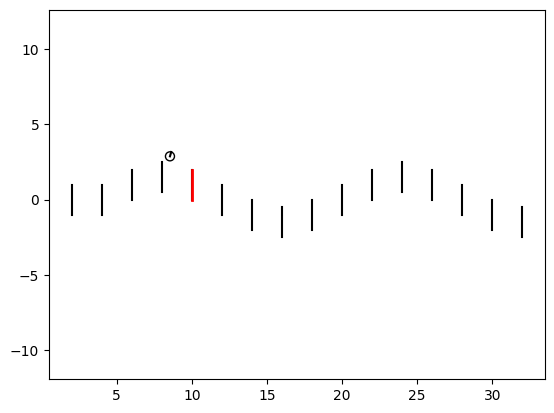

[ 8.549805   2.876589   0.9515618  1.6676418 24.       ]


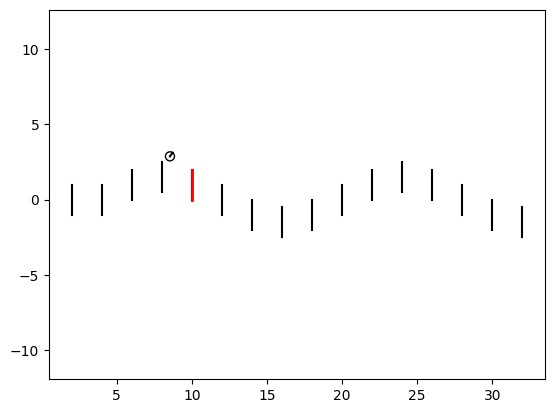

[ 8.549805    2.876589    0.63293034  1.6676418  25.        ]


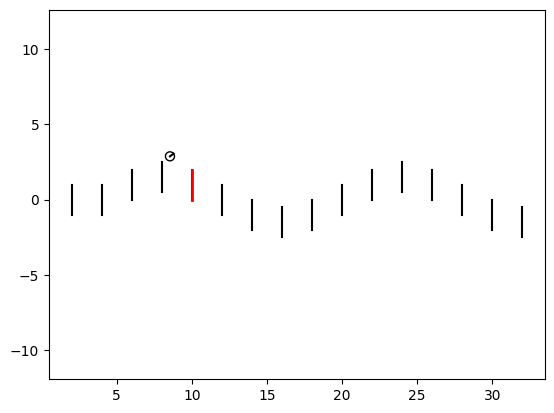

[ 8.549805    2.876589    0.35753414  1.6676418  26.        ]


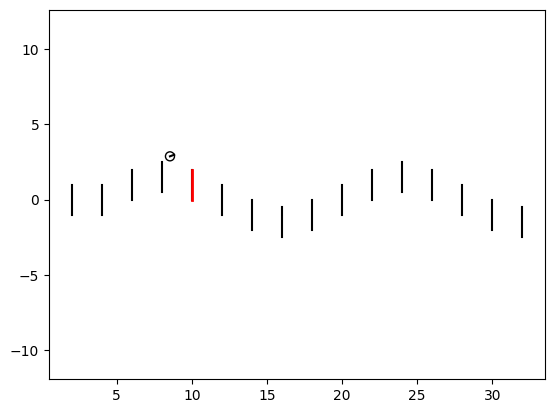

[ 8.549805    2.876589    0.05597772  1.6676418  27.        ]


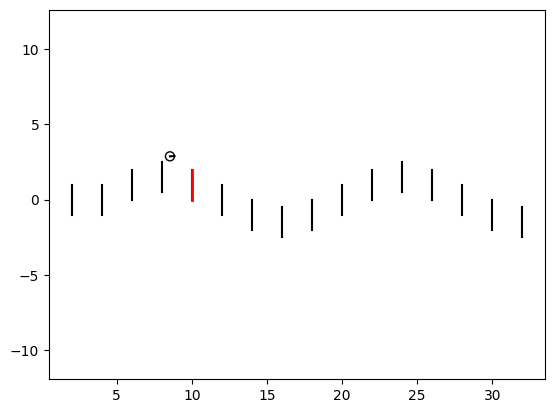

[ 8.549805   2.876589  -0.2967654  1.6676418 28.       ]


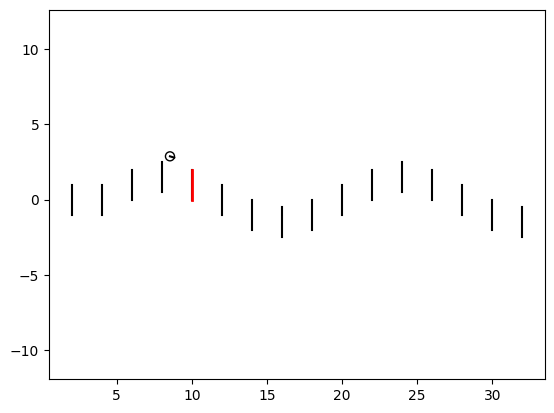

[ 8.549805   2.876589  -0.6734646  1.6676418 29.       ]


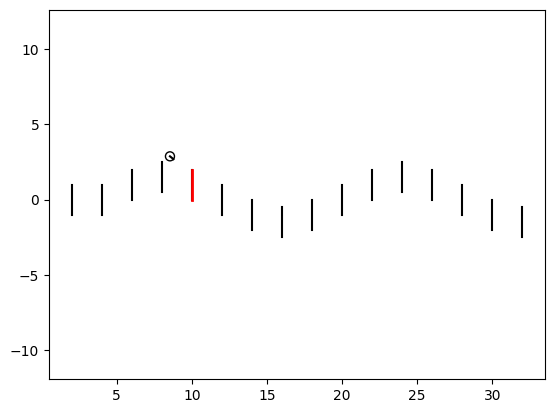

[ 8.549805   2.876589  -1.0427533  1.6676418 30.       ]


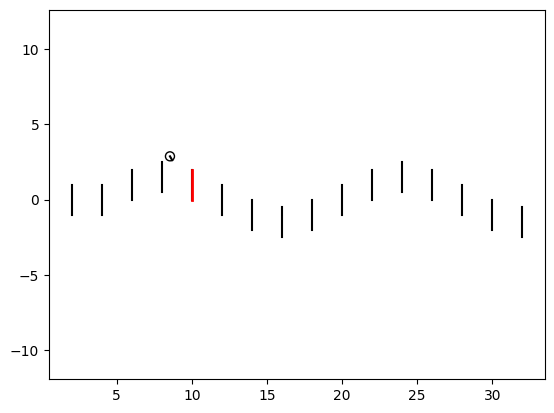

[ 8.549805   2.876589  -1.1232111  1.6676418 31.       ]


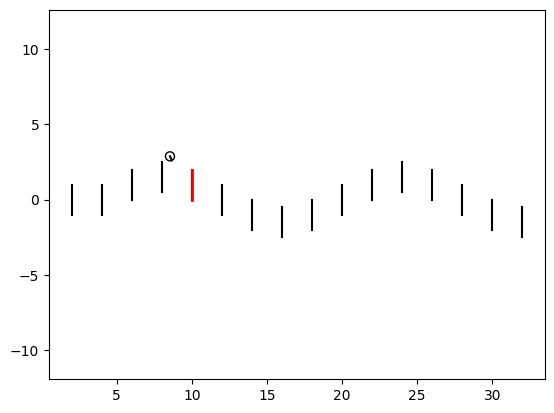

[ 8.549805   2.876589  -1.424434   1.6676418 32.       ]


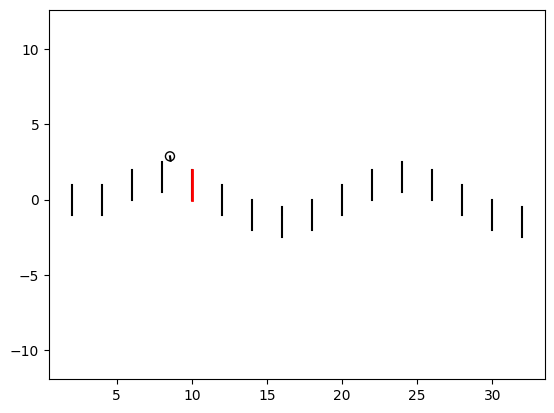

[ 8.549805   2.876589  -1.6879227  1.6676418 33.       ]


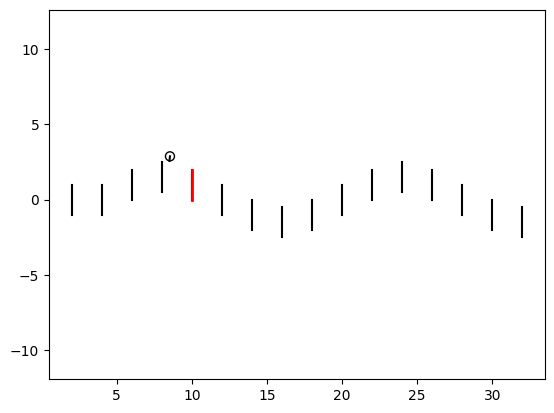

[ 8.549805   2.876589  -1.9223149  1.6676418 34.       ]


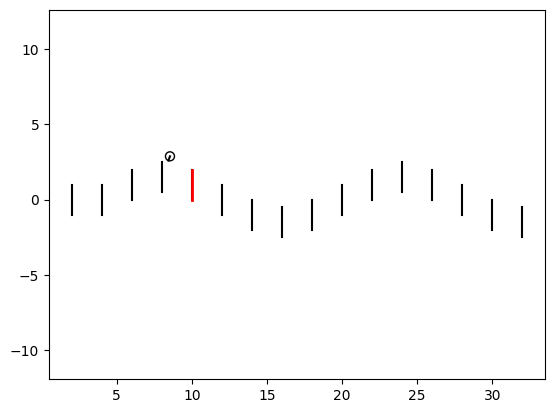

[ 8.549805   2.876589  -1.708335   1.6676418 35.       ]


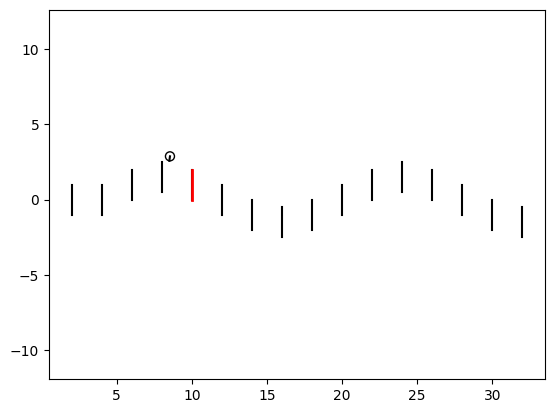

[ 8.549805   2.876589  -1.7250394  1.6676418 36.       ]


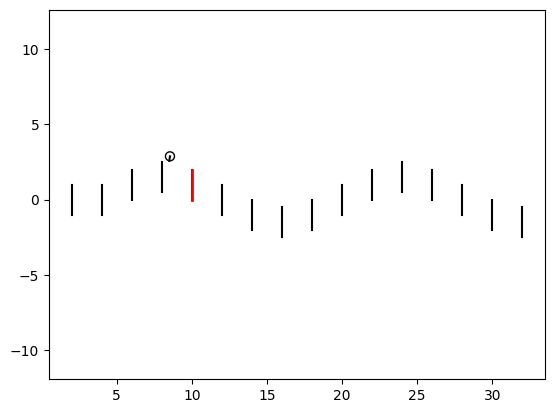

[ 8.549805   2.876589  -1.8799216  1.6676418 37.       ]


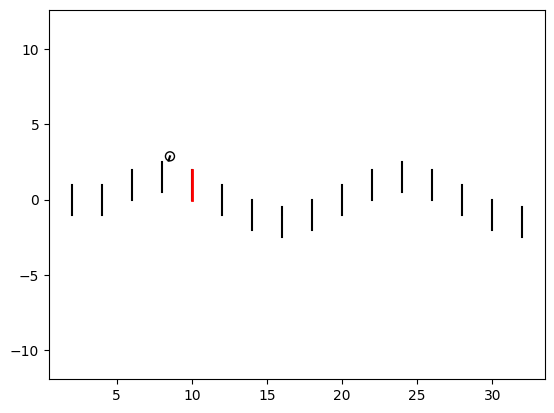

[ 8.549805   2.876589  -1.9198779  1.6676418 38.       ]


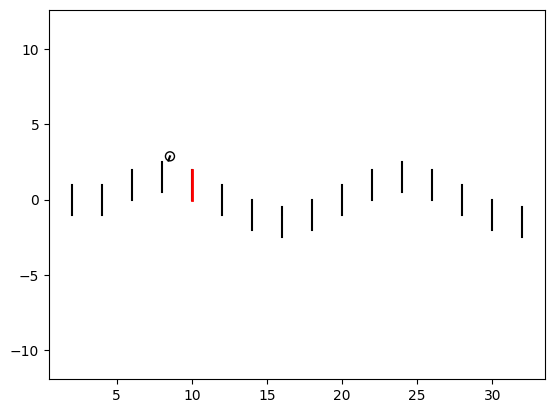

[ 8.549805   2.876589  -1.844673   1.6676418 39.       ]


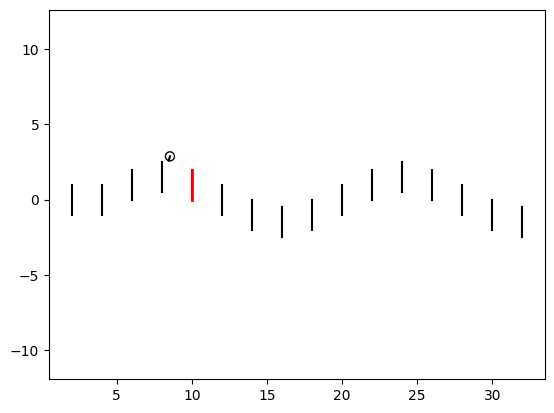

[ 8.549805   2.876589  -1.5720904  1.6676418 40.       ]


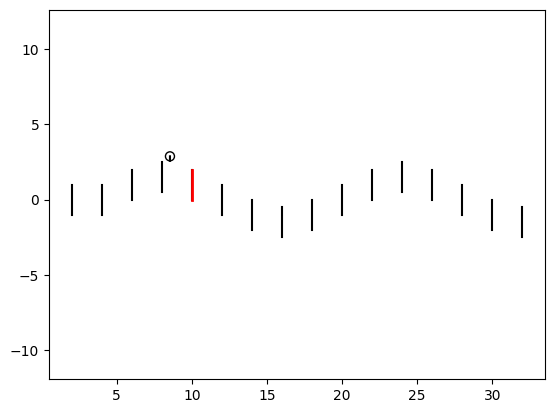

[ 8.549805   2.876589  -1.6183513  1.6676418 41.       ]


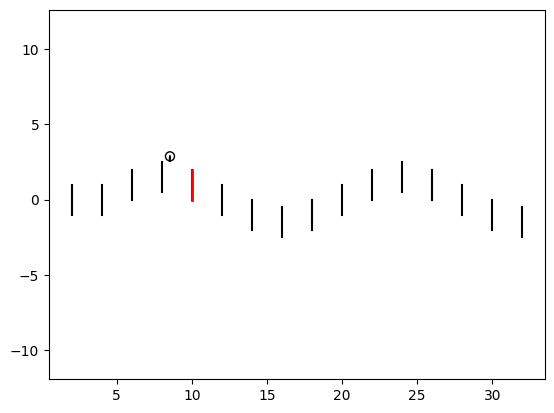

[ 8.549805   2.876589  -1.5669159  1.6676418 42.       ]


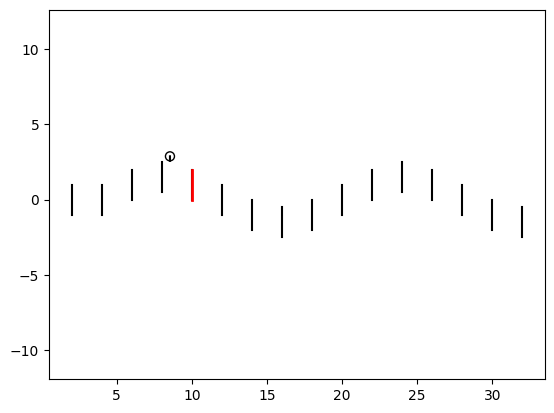

[ 8.549805   2.876589  -1.7969826  1.6676418 43.       ]


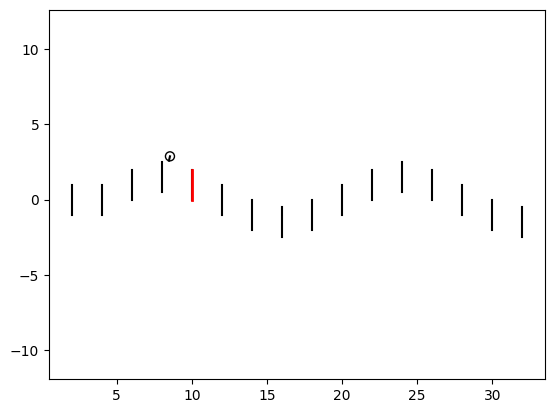

[ 8.549805   2.876589  -1.5107111  1.6676418 44.       ]


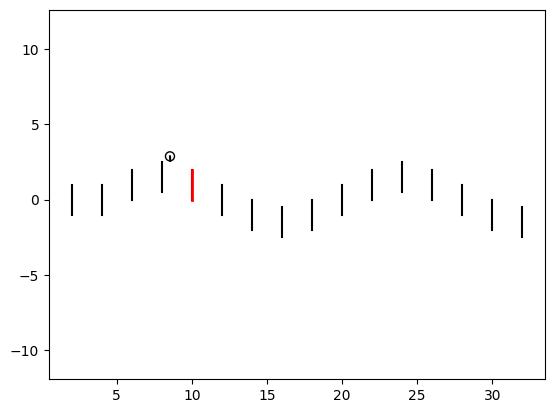

[ 8.549805   2.876589  -1.4449799  1.6676418 45.       ]


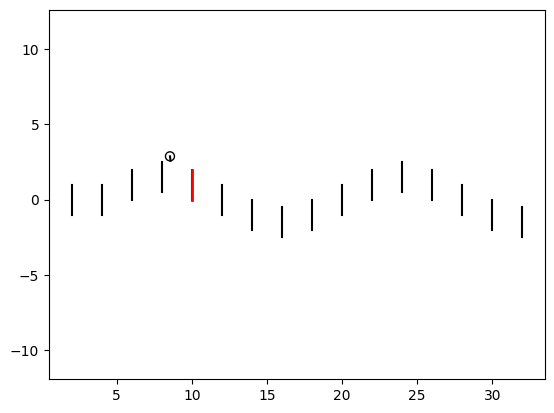

[ 8.549805   2.876589  -1.1082973  1.6676418 46.       ]


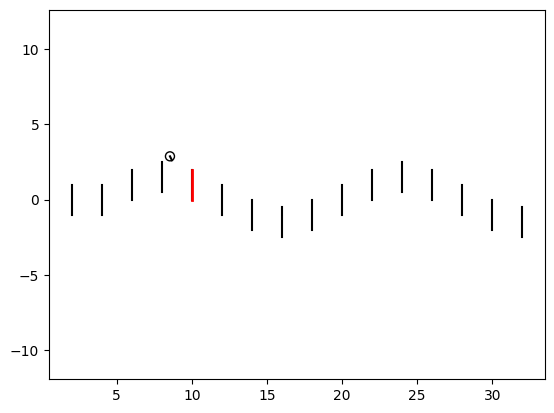

[ 8.549805    2.876589   -0.80351645  1.6676418  47.        ]


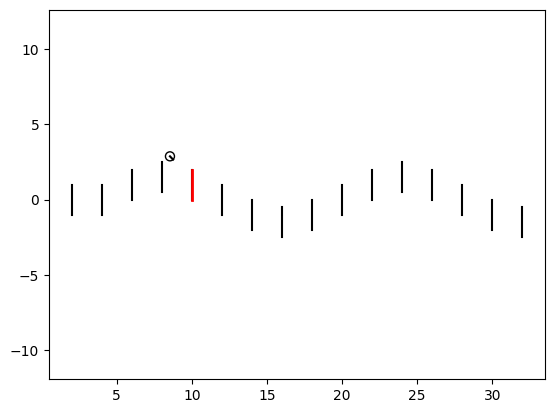

[ 8.549805   2.876589  -0.6461745  1.6676418 48.       ]


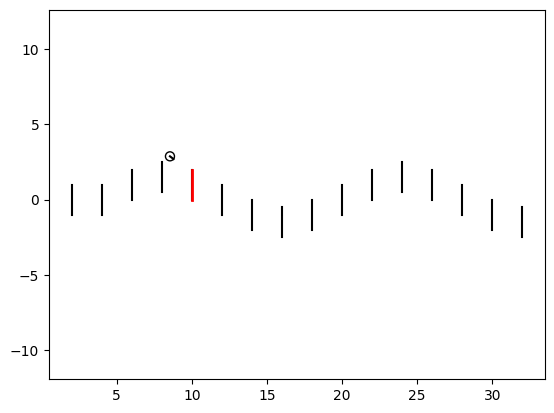

[ 8.549805    2.876589   -0.39263502  1.6676418  49.        ]


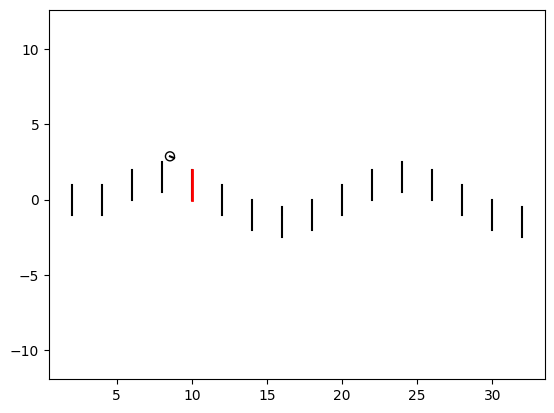

[ 8.549805    2.876589   -0.21240039  1.6676418  50.        ]


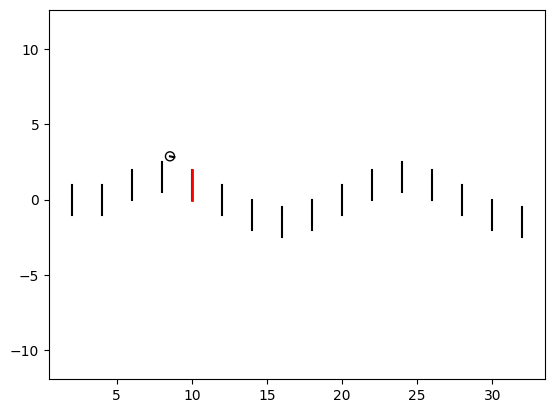

[ 8.549805   2.876589  -0.1263104  1.6676418 51.       ]


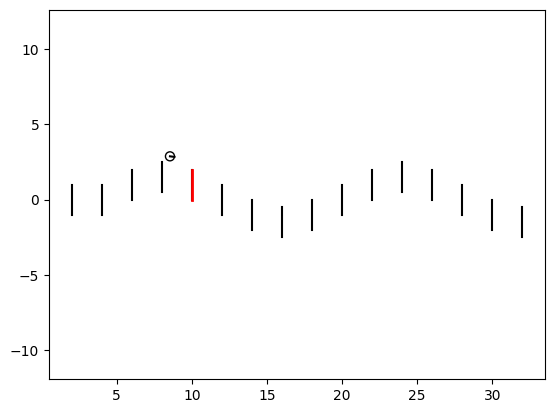

[ 8.549805    2.876589    0.10066285  1.6676418  52.        ]


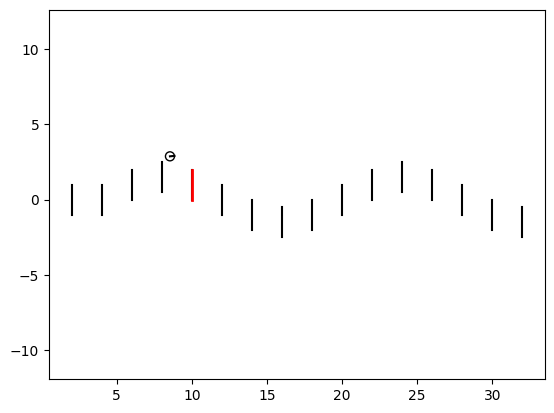

[8.5498047e+00 2.8765891e+00 5.4079271e-03 1.6676418e+00 5.3000000e+01]


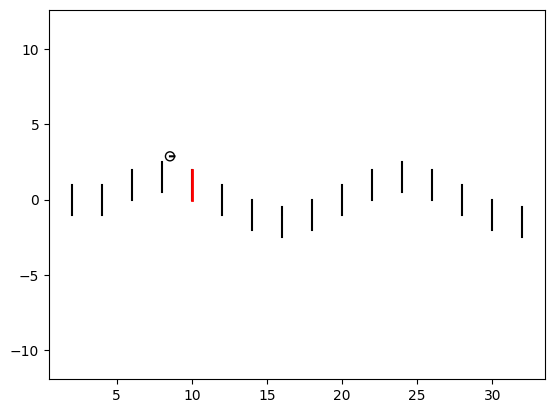

[ 8.549805    2.876589    0.29664758  1.6676418  54.        ]


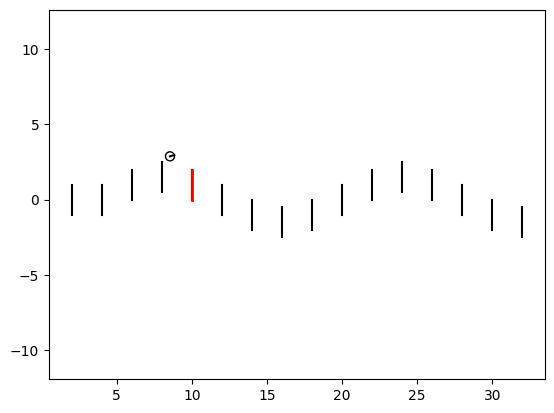

[ 8.549805   2.876589   0.4089595  1.6676418 55.       ]


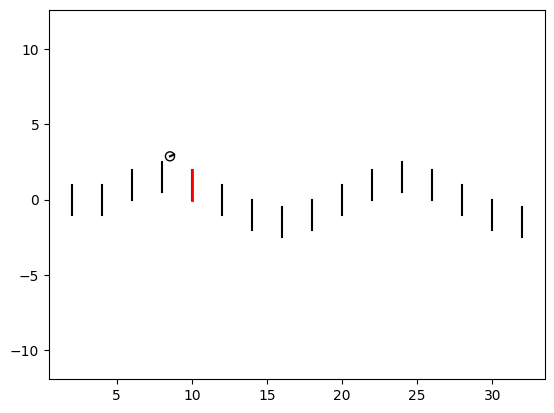

[ 8.549805    2.876589    0.38960046  1.6676418  56.        ]


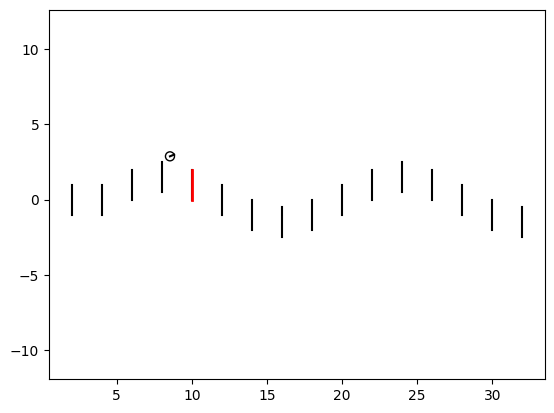

[ 8.549805    2.876589    0.67817885  1.6676418  57.        ]


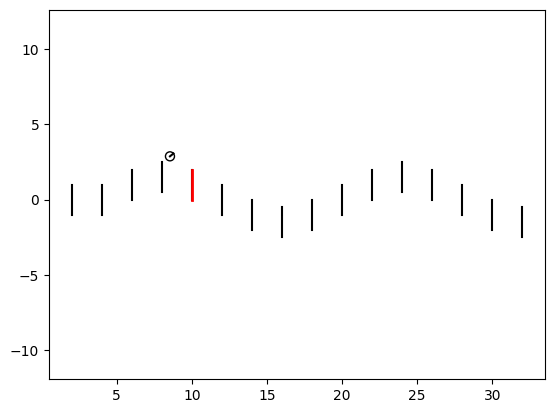

[ 8.549805   2.876589   0.8414109  1.6676418 58.       ]


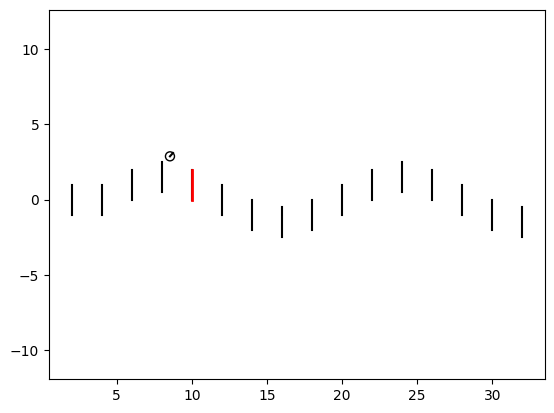

[ 8.549805    2.876589    0.81635106  1.6676418  59.        ]


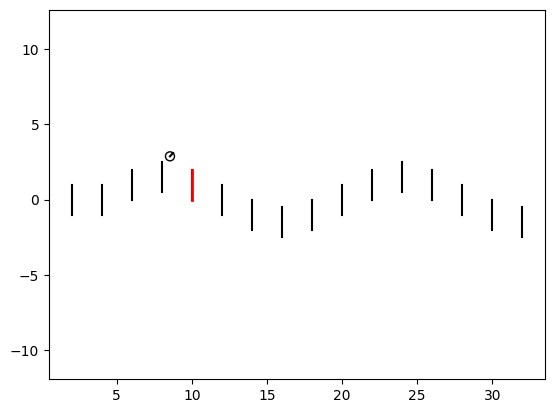

[ 8.549805   2.876589   0.8621961  1.6676418 60.       ]


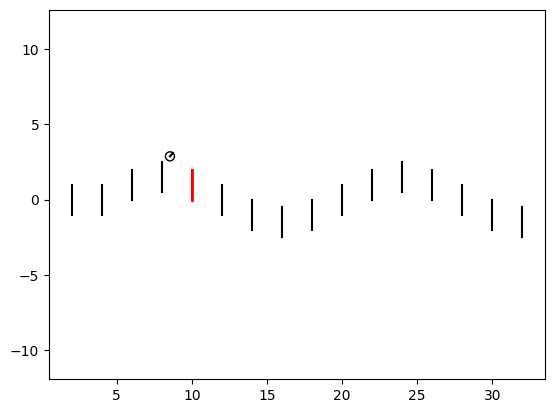

[ 8.549805   2.876589   0.7677151  1.6676418 61.       ]


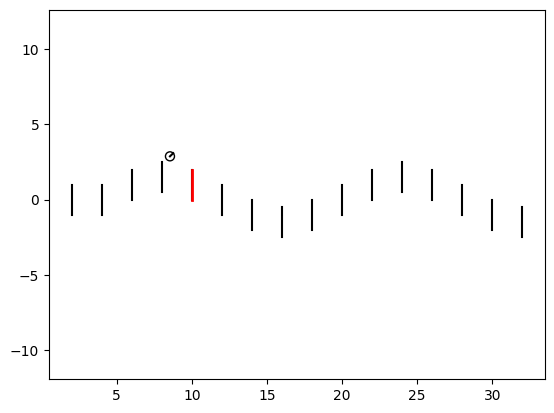

[ 8.549805   2.876589   0.925884   1.6676418 62.       ]


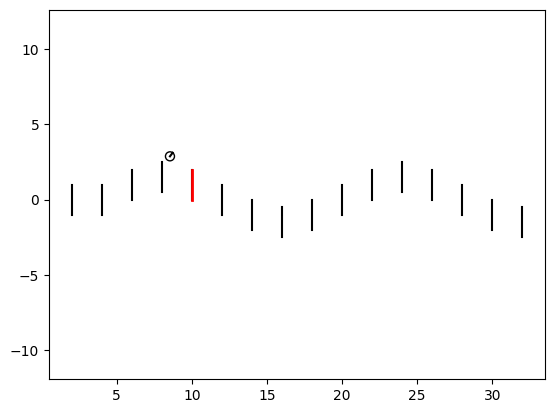

[ 8.549805   2.876589   1.0927926  1.6676418 63.       ]


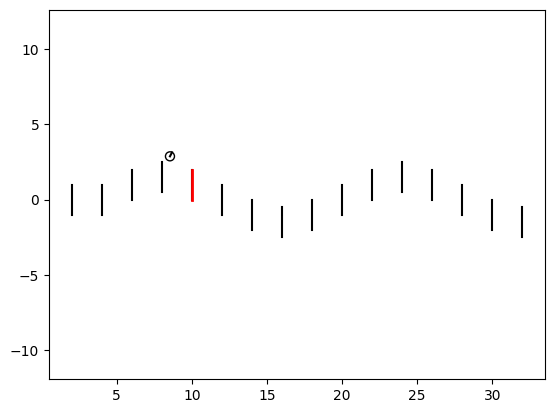

[ 8.549805   2.876589   1.3676821  1.6676418 64.       ]


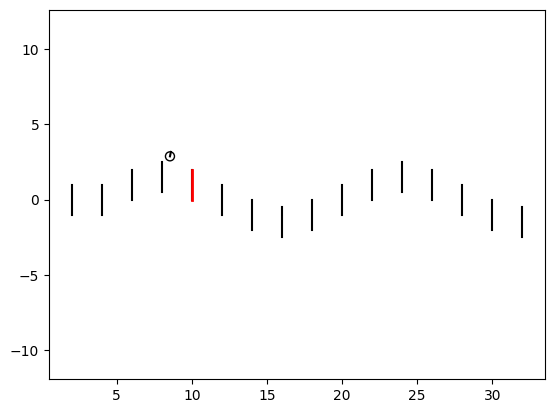

[ 8.549805   2.876589   1.4484768  1.6676418 65.       ]


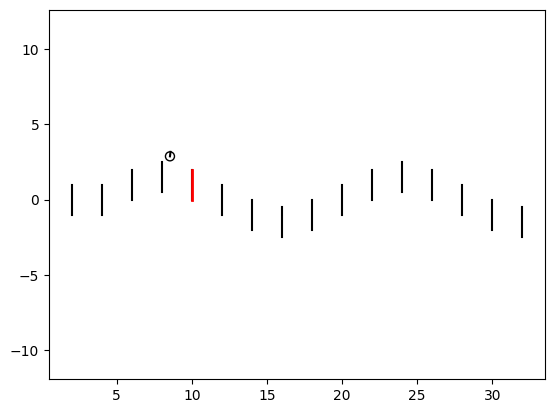

[ 8.549805   2.876589   1.7438678  1.6676418 66.       ]


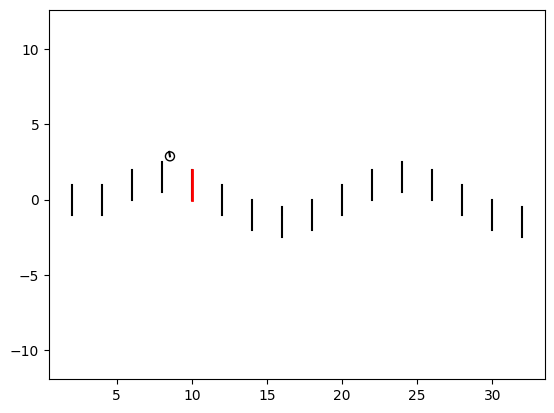

[ 8.486534   3.2385035  1.6308537  1.6141857 67.       ]


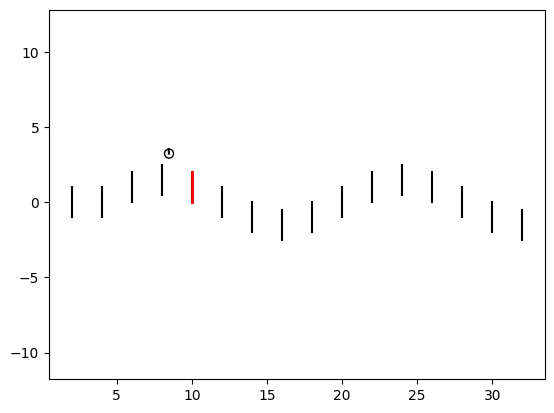

[ 8.486534   3.2385035  1.8182932  1.6141857 68.       ]


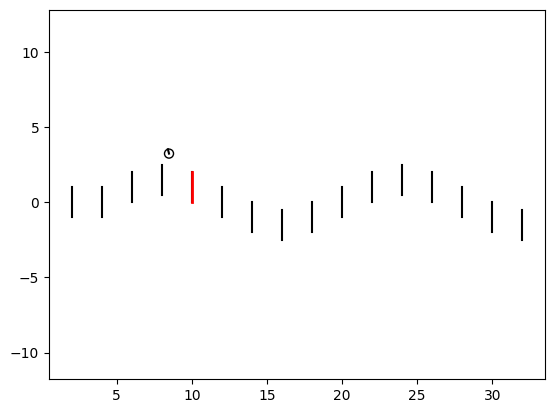

[ 8.486534   3.2385035  1.6504908  1.6141857 69.       ]


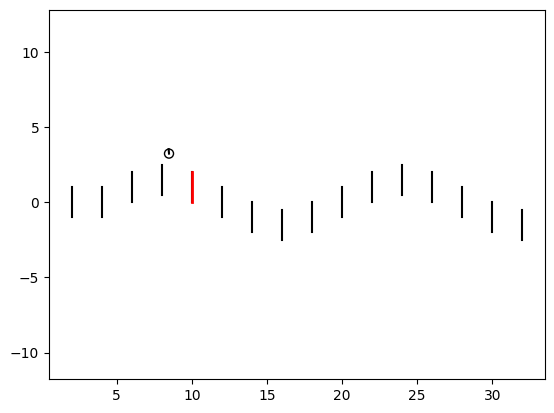

[ 8.486534   3.2385035  1.8551927  1.6141857 70.       ]


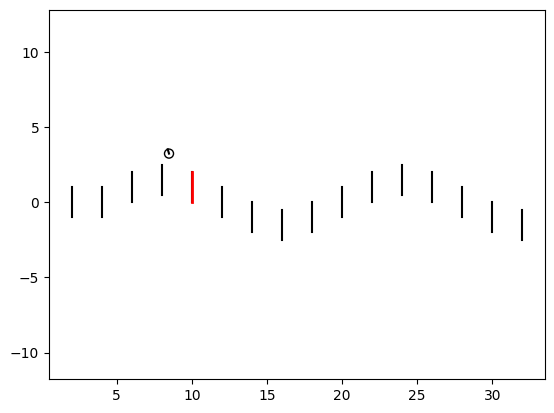

[ 8.486534   3.2385035  2.163205   1.6141857 71.       ]


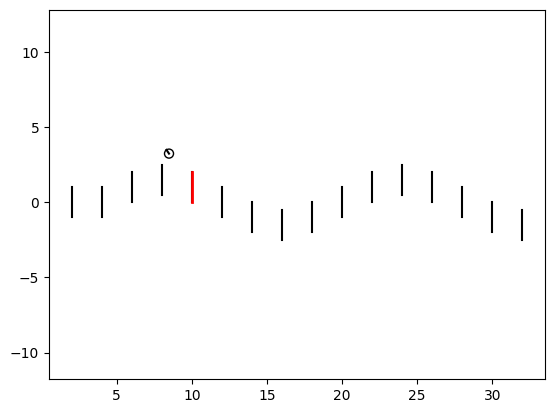

[ 8.486534   3.2385035  1.9122983  1.6141857 72.       ]


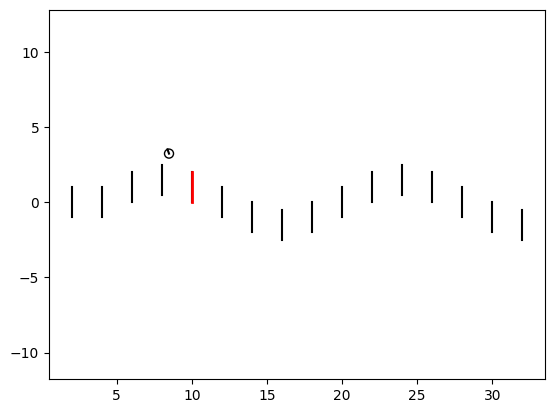

[ 8.486534   3.2385035  1.8222997  1.6141857 73.       ]


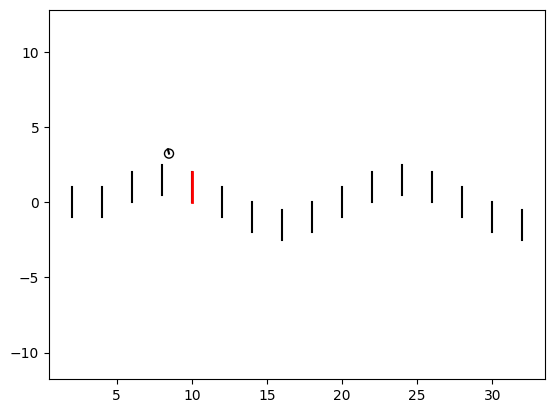

[ 8.486534   3.2385035  2.0454538  1.6141857 74.       ]


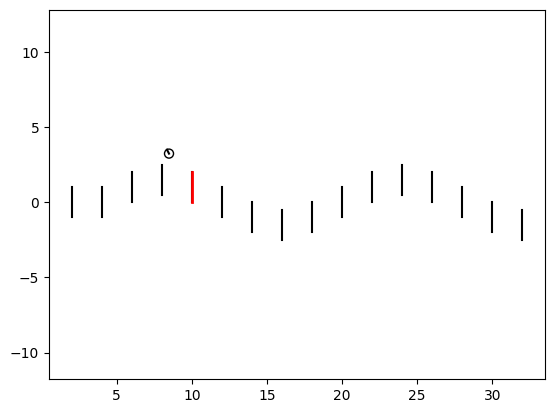

[ 8.486534   3.2385035  1.9097819  1.6141857 75.       ]


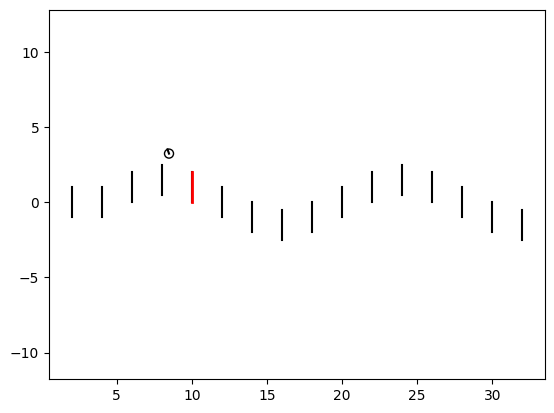

[ 8.486534   3.2385035  2.1089091  1.6141857 76.       ]


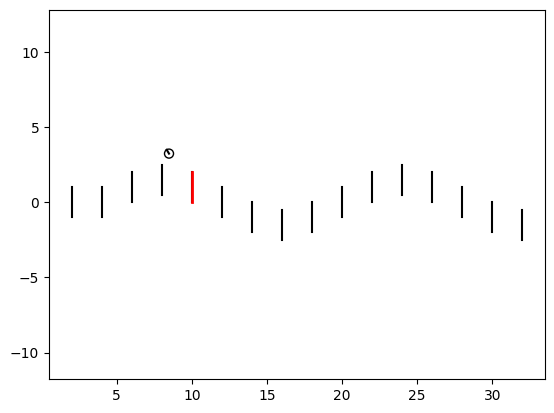

[ 8.486534   3.2385035  2.2778845  1.6141857 77.       ]


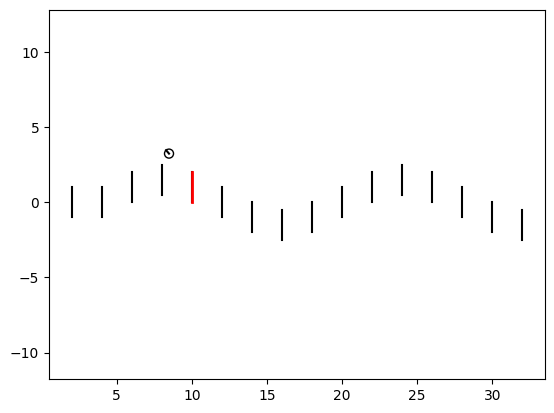

[ 8.486534   3.2385035  2.498284   1.6141857 78.       ]


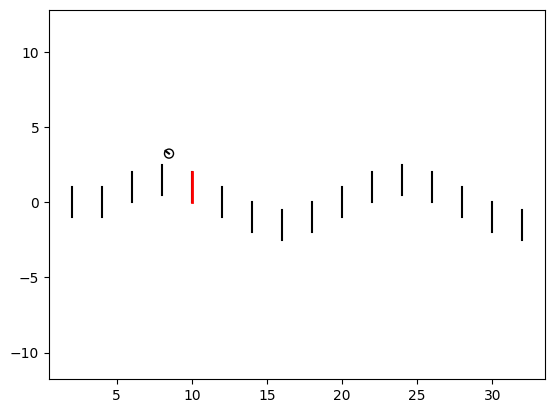

[ 8.486534   3.2385035  2.498284   1.6141857 79.       ]


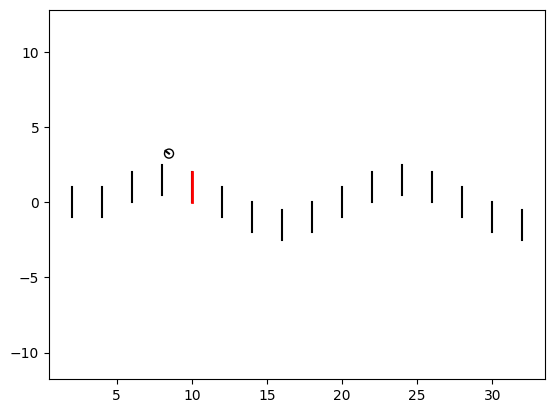

[4,
 -2,
 -3,
 -4,
 -5,
 -6,
 -7,
 -8,
 -9,
 -10,
 -11,
 -12,
 -13,
 6,
 -1,
 -2,
 11,
 4,
 -2,
 16,
 -1,
 21,
 -1,
 -2,
 -3,
 -4,
 -5,
 -6,
 -7,
 -8,
 -9,
 -10,
 -11,
 -22,
 -13,
 -24,
 -15,
 -16,
 -17,
 -18,
 -19,
 -20,
 -21,
 -22,
 -23,
 -24,
 -25,
 -26,
 -27,
 -28,
 -29,
 -30,
 -31,
 -32,
 -33,
 -34,
 -35,
 -36,
 -37,
 -38,
 -39,
 -40,
 -41,
 -42,
 -43,
 -44,
 -45,
 -46,
 -47,
 -48,
 -49,
 -50,
 -51,
 -52,
 -53,
 -54,
 -55,
 -56,
 -57,
 -58,
 -59,
 -60,
 -61,
 -62,
 -63,
 -64,
 -65,
 -66,
 -67,
 -68,
 -69,
 -70,
 -71,
 -72,
 -73,
 -74,
 -75,
 -76,
 -77,
 -78,
 -79]

In [27]:
run_env(test, sac)

In [15]:
test.action_space

Box([-4. -2.], [4. 2.], (2,), float64)